[19685 15748 15525  9772  7149  7247  4336 13848 12039  3721]
[[0.9734 0.9951]
 [0.6085 0.9663]
 [0.6787 0.8738]
 ...
 [0.4332 0.8007]
 [0.5364 0.9517]
 [0.8144 0.2208]]
[0.98425 0.7874  0.77625 ... 0.61695 0.74405 0.5176 ]
Epoch 0, Loss: 0.165715
Epoch 10, Loss: 0.133686
Epoch 20, Loss: 0.120279
Epoch 30, Loss: 0.110319


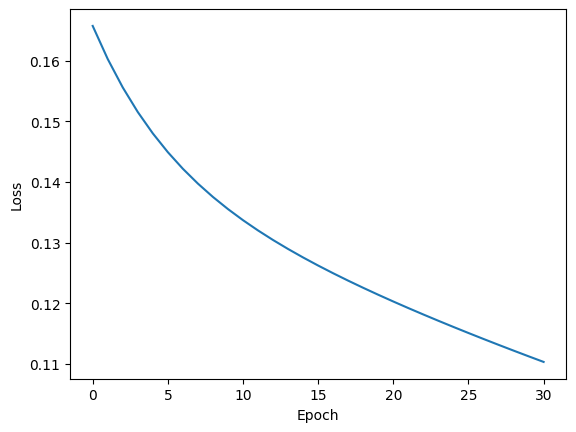

Epoch 0, Loss: 0.218934
Epoch 10, Loss: 0.108138
Epoch 20, Loss: 0.075239
Epoch 30, Loss: 0.064238


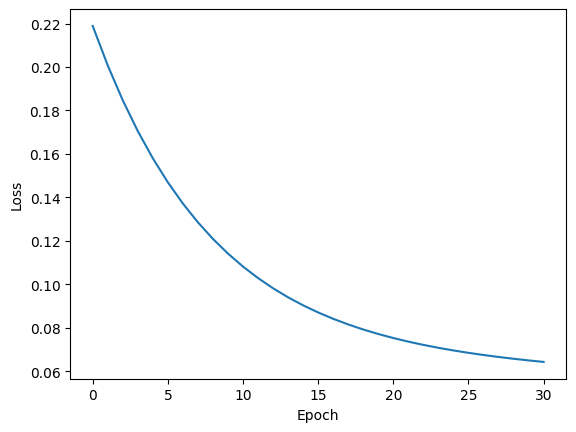

Epoch 0, Loss: 0.208703
Epoch 10, Loss: 0.099298
Epoch 20, Loss: 0.052157
Epoch 30, Loss: 0.032037


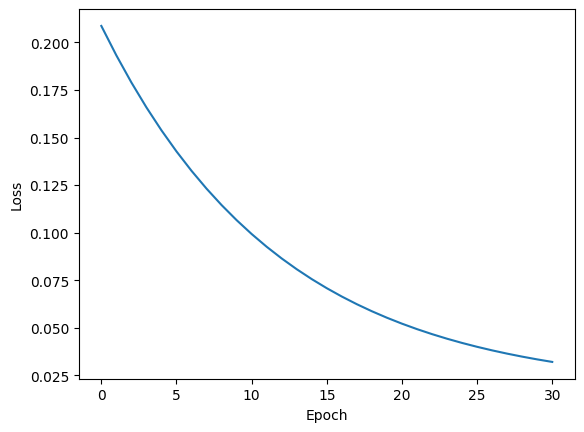

Epoch 0, Loss: 0.027344
Epoch 10, Loss: 0.006850
Epoch 20, Loss: 0.001909
Epoch 30, Loss: 0.000697


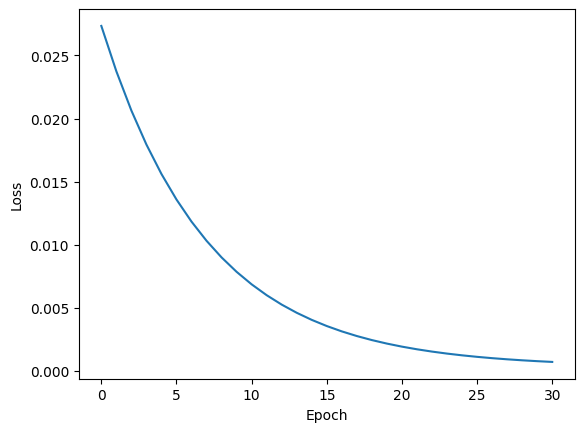

Epoch 0, Loss: 0.638066
Epoch 10, Loss: 0.255704
Epoch 20, Loss: 0.169366
Epoch 30, Loss: 0.141816


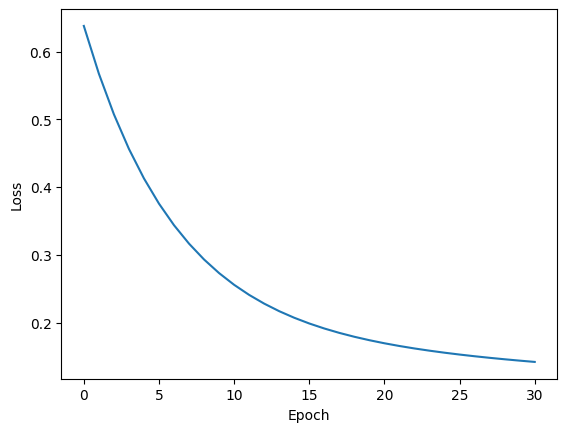

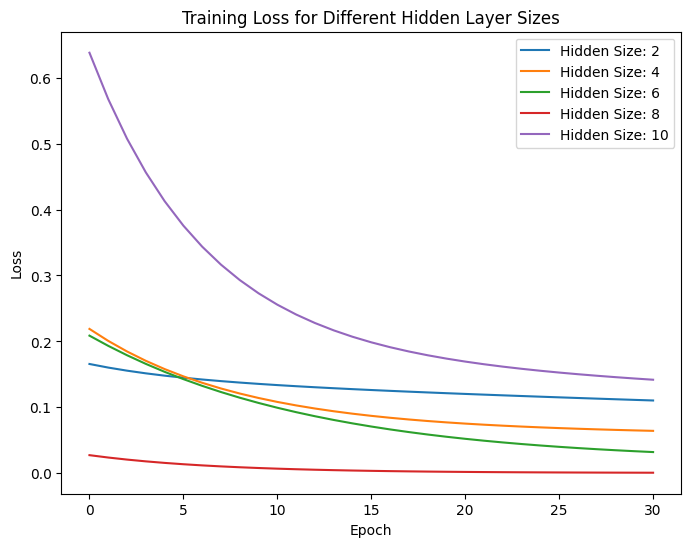

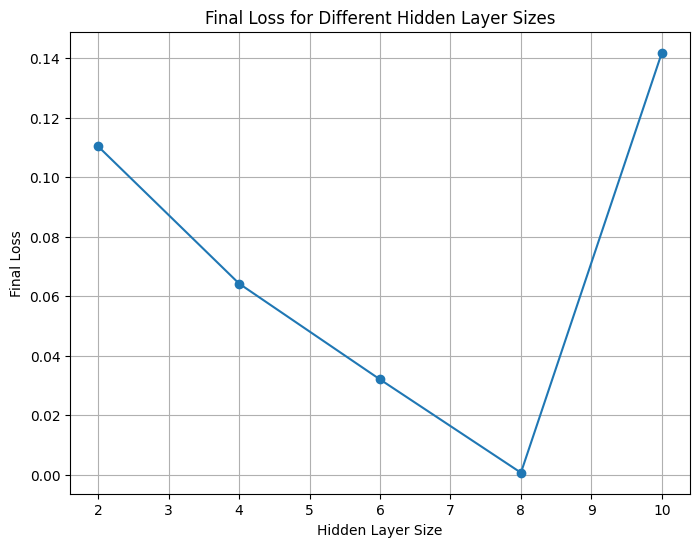

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 生成数据集
def generate_dataset(num_samples):
    #X = np.random.rand(num_samples, 2)  
    X=np.random.randint(1000, 9999, size=(10000, 2))# 随机生成两个四位数的输入
    y = np.sum(X, axis=1)  # 计算两个输入的和作为输出
    return X, y

# 数据正则化
def normalize_data(X, y):
    X_normalized = X / 10000.0  # 将输入正则化到0-1范围内（四位数的最大值为9999）
    y_normalized = y / 20000.0  # 将输出正则化到0-1范围内（两个四位数的和的最大值为19998）
    return X_normalized, y_normalized

# 反正规化输出
def denormalize_output(y_normalized):
    return y_normalized * 20000  # 将输出反正规化到原始范围内

# 定义 TanH 激活函数
def tanh(x):
    return np.tanh(x)

# 定义线性激活函数
def linear(x):
    return x

def tanh_derivative(x):
    return 1.0 - np.tanh(x)**2

def linear_derivative(x):
    return 1
def mse_loss_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size
# 定义神经网络模型
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # 初始化权重和偏置
        limit_input_hidden = np.sqrt(6 / (input_size + hidden_size))
        self.weights_input_hidden = np.random.uniform(-limit_input_hidden, limit_input_hidden, (input_size, hidden_size))
        self.bias_input_hidden = np.zeros((1, hidden_size))
        
        limit_hidden_output = np.sqrt(6 / (hidden_size + output_size))
        self.weights_hidden_output = np.random.uniform(-limit_hidden_output, limit_hidden_output, (hidden_size, output_size))
        self.bias_hidden_output = np.zeros((1, output_size))
    def forward(self, X):
        # 前向传播
        self.input_to_hidden = np.dot(X, self.weights_input_hidden) + self.bias_input_hidden
        self.input_to_hidden_act = tanh(self.input_to_hidden)
        self.hidden_to_output = np.dot(self.input_to_hidden_act, self.weights_hidden_output) + self.bias_hidden_output
        self.output = linear(self.hidden_to_output)
        return self.input_to_hidden,self.input_to_hidden_act,self.hidden_to_output,self.output
    def predict(self, X):
        a,b,c,output=self.forward(X)
        output=denormalize_output(output)
        return output      
    def backward(self, X, y, z1, a1, z2, y_pred, W2):
        dloss_doutput = mse_loss_derivative(y, y_pred)
        doutput_dz2 = linear_derivative(z2)
        
        dz2_dW2 = a1
        dz2_db2 = 1
        dz2_da1 = W2
        
        da1_dz1 = tanh_derivative(z1)
        dz1_dW1 = X
        dz1_db1 = 1
        
        dloss_dz2 = dloss_doutput * doutput_dz2
        dloss_da1 = np.dot(dloss_dz2, W2.T)
        dloss_dz1 = dloss_da1 * da1_dz1
        
        dloss_dW2 = np.dot(dz2_dW2.T, dloss_dz2)
        dloss_db2 = np.sum(dloss_dz2 * dz2_db2, axis=0, keepdims=True)
        dloss_dW1 = np.dot(dz1_dW1.T, dloss_dz1)
        dloss_db1 = np.sum(dloss_dz1 * dz1_db1, axis=0, keepdims=True)
        
        return dloss_dW1, dloss_db1, dloss_dW2, dloss_db2
    
    def train(self, X, y, learning_rate, num_epochs):
        y = y.reshape(-1, 1)  # 確保 y 的形狀是 (n, 1)
        self.loss_history = []
        
        for epoch in range(num_epochs+1):
            # 前向传播
            z1, a1, z2, y_pred = self.forward(X)
            
            # 计算误差
            #print('y_pred',y_pred[0])
            #print('y',y[0])
            loss = np.mean((y_pred - y) ** 2)
            ####################################################################################################
            
            #loss = np.mean((y_pred - y))
            self.loss_history.append(loss)
            
            # 計算梯度
            dW1, db1, dW2, db2 = self.backward(X, y, z1, a1, z2, y_pred, self.weights_hidden_output)
            #print(dW1.shape)
            # 更新權重和偏差
            self.weights_hidden_output -= learning_rate * dW2
            self.bias_hidden_output -= learning_rate * db2
            self.weights_input_hidden -= learning_rate * dW1
            self.bias_input_hidden -= learning_rate * db1
            
            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {loss:.6f}')
        
        plt.plot(self.loss_history)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()



# 创建数据集
X, y = generate_dataset(10000)
#print(X[:10])
print(y[:10])
X_normalized, y_normalized = normalize_data(X, y)
print(X_normalized)
print(y_normalized)
#print(X_normalized[:10])
# 切分数据集为训练集和测试集
split_ratio = 0.8
split_index = int(len(X_normalized) * split_ratio)
X_train, X_test = X_normalized[:split_index], X_normalized[split_index:]
y_train, y_test = y_normalized[:split_index], y_normalized[split_index:]
#print(X_train.shape)
#print(X_test.shape)
# 创建神经网络模型
input_size = 2
hidden_size_list = [2, 4, 6, 8, 10]  # 不同隐藏层神经元数量
output_size = 1
num_epochs = 30
learning_rate = 0.01

# 用于存储不同模型的训练损失曲线
loss_history_list = []
models=[]

# 遍历不同的隐藏层大小
for hidden_size in hidden_size_list:
    # 创建模型
    model = NeuralNetwork(input_size, hidden_size, output_size)
    30
    # 训练模型
    model.train(X_train, y_train, learning_rate, num_epochs)

    models.append(model)
    # 记录训练损失
    loss_history_list.append(model.loss_history)

# 绘制不同隐藏层大小的训练损失曲线
plt.figure(figsize=(8, 6))
for i, hidden_size in enumerate(hidden_size_list):
    plt.plot(range(num_epochs+1), loss_history_list[i], label=f'Hidden Size: {hidden_size}')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title('Training Loss for Different Hidden Layer Sizes')
plt.show()



final_losses = []

# Train and record final losses for each model
for model, hidden_size in zip(models, hidden_size_list):
    final_loss = model.loss_history[-1]
    final_losses.append(final_loss)

# Plot the final losses vs. hidden layer sizes as a line plot
plt.figure(figsize=(8, 6))
plt.plot(hidden_size_list, final_losses, marker='o', linestyle='-')
plt.xlabel("Hidden Layer Size")
plt.ylabel("Final Loss")
plt.title('Final Loss for Different Hidden Layer Sizes')
plt.grid(True)  # Add grid lines
plt.show()

In [6]:
print(len(models))
print(models[].predict([5555,5678]))


5
[[29056.76758688]]


In [90]:
import numpy as np
import matplotlib.pyplot as plt

# 生成数据集
def generate_dataset(num_samples):
    X = np.random.rand(num_samples, 2)  # 随机生成两个四位数的输入
    y = np.sum(X, axis=1)  # 计算两个输入的和作为输出
    return X, y

# 数据正则化
def normalize_data(X, y):
    X_normalized = X / 9.0  # 将输入正则化到0-1范围内（四位数的最大值为9999）
    y_normalized = y / 18.0  # 将输出正则化到0-1范围内（两个四位数的和的最大值为19998）
    return X_normalized, y_normalized

# 反正规化输出
def denormalize_output(y_normalized):
    return y_normalized * 18.0  # 将输出反正规化到原始范围内

# 定义 TanH 激活函数
def tanh(x):
    return np.tanh(x)

# 定义线性激活函数
def linear(x):
    return x


# 定义神经网络模型
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        X = np.random.rand(num_samples, 2)
        '''
        # 初始化权重和偏置
        self.weights_input_hidden = np.random.randn(input_size, hidden_size)
        self.bias_input_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size)
        self.bias_hidden_output = np.zeros((1, output_size))
        '''
        
        # 初始化权重和偏置（Xavir）
        limit1 = np.sqrt(6/(input_size + hidden_size))
        self.weights_input_hidden = np.random.uniform(-limit1,limit1,(input_size,hidden_size))
        self.bias_input_hidden = np.zeros((1,hidden_size))
        limit2 = np.sqrt(6/(hidden_size + output_size))
        self.weights_hidden_output =np.random.uniform(-limit2,limit2,(hidden_size, output_size))
        self.bias_hidden_output = np.zeros((1,output_size))
        
    def forward(self, X):
        # 前向传播
        self.hidden_input = np.dot(X, self.weights_input_hidden) + self.bias_input_hidden
        self.hidden_output = tanh(self.hidden_input)
        self.final_output = linear(np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_hidden_output)
        return self.final_output
    
    def train(self, X, y, learning_rate, num_epochs):
        y=y.reshape(-1,1)
        self.loss_history = []
        for epoch in range(num_epochs):
            # 前向传播
            y_pred = self.forward(X)
            
            # 计算误差
            loss = 0.5 * np.mean((y_pred - y) ** 2)
            self.loss_history.append(loss)
            
            # 反向传播
            delta_output = y_pred - y
            delta_hidden = np.dot(delta_output, self.weights_hidden_output.T) * (1 - np.tanh(self.hidden_input) ** 2)
            
            # 更新权重和偏置
            self.weights_hidden_output -= learning_rate * np.dot(self.hidden_output.T, delta_output)
            self.bias_hidden_output -= learning_rate * np.sum(delta_output, axis=0, keepdims=True)
            self.weights_input_hidden -= learning_rate * np.dot(X.T, delta_hidden)
            self.bias_input_hidden -= learning_rate * np.sum(delta_hidden, axis=0, keepdims=True)
    
    def predict(self, X):
        return self.forward(X)

# 创建数据集
X, y = generate_dataset(10000)
X_normalized, y_normalized = normalize_data(X, y)

# 切分数据集为训练集和测试集
split_ratio = 0.8
split_index = int(len(X_normalized) * split_ratio)
X_train, X_test = X_normalized[:split_index], X_normalized[split_index:]
y_train, y_test = y_normalized[:split_index], y_normalized[split_index:]

# 创建不同隐藏层神经元数量的模型并记录训练损失
hidden_size_list = [2, 4, 6, 8, 10]  # 不同隐藏层神经元数量
num_epochs = 30
learning_rate = 0.00015
models = []

plt.figure(figsize=(12, 8))

for hidden_size in hidden_size_list:
    model = NeuralNetwork(input_size, hidden_size, output_size)
    model.train(X_train, y_train, learning_rate, num_epochs)
    models.append(model)
    
    # 绘制训练损失曲线
    plt.plot(model.loss_history, label=f'Hidden Size: {hidden_size}')

# 验证模型性能并输出结果
for i, model in enumerate(models):
    y_pred_test = model.predict(X_test)
    denormalized_y_pred_test = denormalize_output(y_pred_test)
    denormalized_y_test = denormalize_output(y_test)
    
    mse = np.mean((denormalized_y_pred_test - denormalized_y_test) ** 2)
    mae = np.mean(np.abs(denormalized_y_pred_test - denormalized_y_test))
    
    print(f'Model {i+1} (Hidden Size: {hidden_size_list[i]}):')
    print(f'Mean Squared Error (MSE): {mse:.6f}')
    print(f'Mean Absolute Error (MAE): {mae:.6f}')
    print()

plt.title('Training Loss for Different Hidden Layer Sizes')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'num_samples' is not defined

<Figure size 1200x800 with 0 Axes>

In [38]:
print(len(models))

5


In [89]:
import numpy as np

# 生成四位数的数据对
def generate_example():
    num1 = np.random.randint(1000, 9999)  # 生成一个四位数
    num2 = np.random.randint(1000, 9999)  # 生成另一个四位数
    X = np.array([[num1, num2]])  # 将两个四位数作为输入
    y = num1 + num2  # 计算两个四位数的和作为输出
    return X, y

# 数据正则化
def normalize_data(X, y):
    X_normalized = X / 9999.0  # 将输入正则化到0-1范围内（四位数的最大值为9998）
    y_normalized = y / 19998.0  # 将输出正则化到0-1范围内（两个四位数的和的最大值为19998）
    return X_normalized, y_normalized

# 反正规化输出
def denormalize_output(y_normalized):
    return y_normalized * 19998.0  # 将输出反正规化到原始范围内

# 定义 TanH 激活函数
def tanh(x):
    return np.tanh(x)

# 定义线性激活函数
def linear(x):
    return x

# 定义神经网络模型
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # 初始化权重和偏置
        self.weights_input_hidden = np.random.randn(input_size, hidden_size)
        self.bias_input_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size)
        self.bias_hidden_output = np.zeros((1, output_size))
        
    def forward(self, X):
        # 前向传播
        self.hidden_input = np.dot(X, self.weights_input_hidden) + self.bias_input_hidden
        self.hidden_output = tanh(self.hidden_input)
        self.final_output = linear(np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_hidden_output)
        return self.final_output

# 创建数据示例
X_example, y_example = generate_example()
X_normalized_example, y_normalized_example = normalize_data(X_example, y_example)

# 创建不同隐藏层神经元数量的模型并进行前向传播
input_size = 2
hidden_size_list = [2, 4, 6, 8, 10]  # 不同隐藏层神经元数量
output_size = 1
#models = []

for i in range(0,5):
    model=models[i]
    y_pred_example_normalized = model.forward(X_normalized_example)
    # 反正规化预测输出
    y_pred_example = denormalize_output(y_pred_example_normalized)
    
    # 输出结果
    print(f"Hidden Size: {hidden_size_list[i]}")
    print("输入（两个四位数）:")
    print(X_example)
    print("正确的输出:")
    print(y_example)
    print("模型的预测输出:")
    print(int(y_pred_example))  # 转换为整数形式
    print()


IndexError: list index out of range

In [6]:
import numpy as np

X = np.random.rand(10, 2)

In [7]:
print(X)

[[0.14876844 0.08692405]
 [0.81261252 0.96476064]
 [0.82469381 0.92441635]
 ...
 [0.32359903 0.24277068]
 [0.76875705 0.27753979]
 [0.26117144 0.50139169]]


In [9]:
X=np.random.randint(1000, 10000, size=(10000, 2))
print(X)

[[1358 1459]
 [6266 7268]
 [7138 8610]
 ...
 [2156 4101]
 [7703 7842]
 [4480 4176]]
